<a href="https://colab.research.google.com/github/ambideXtrous9/PyTorch-Models/blob/main/imdb_50k_glove_lstm_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
# Tools for preprocessing input data
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases
from nltk.tokenize import word_tokenize
import nltk
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import gensim
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
%config Completer.use_jedi = False
import spacy  

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

## Text Preprocessing - Punctuations,Stopwords

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def stemm_text(text):
    stemmer = SnowballStemmer("english")
    return ' '.join([stemmer.stem(w) for w in text.split(' ')])

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

In [ ]:
T = df['review'].str.split(' \n\n---\n\n').str[0]
T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
stop = stopwords.words('english')
T = T.apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
#T = T.apply(stemm_text)
#T = T.apply(lemmatize_text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
T.head()

0    one reviewers mentioned watching oz episode yo...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: review, dtype: object

## GloVe - 100d

In [ ]:
def Sentence2Vec(T,embedding_dim = 100,max_length = 120):
    glove_path = '../input/glove6b100dtxt/glove.6B.100d.txt'
    path = glove_path
    tokenizer = Tokenizer()
    text=T
    tokenizer.fit_on_texts(text)
    word_index=tokenizer.word_index
    print("number of word in vocabulary",len(word_index))
    vocab_size = 5000
    trunc_type = 'post'
    oov_tok = '<OOV>'
    padding_type = 'post'
    #print("words in vocab",word_index)
    text_sequence=tokenizer.texts_to_sequences(text)
    text_sequence = pad_sequences(text_sequence, maxlen=max_length, truncating=trunc_type,padding=padding_type)
    print("word in sentences are replaced with word ID",text_sequence)
    size_of_vocabulary=len(tokenizer.word_index) + 1
    print("The size of vocabulary ",size_of_vocabulary)
    embeddings_index = dict()

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    text_shape = text_sequence.shape
    X_train = np.empty((text_shape[0],text_shape[1],embedding_matrix.shape[1]))
    for i in range(text_sequence.shape[0]):
        for j in range(text_sequence.shape[1]):
            X_train[i,j,:] = embedding_matrix[text_sequence[i][j]]
    print(X_train.shape)

    return X_train,embeddings_index,word_index


In [ ]:
X_train,embeddings_index,word_index = Sentence2Vec(T)

number of word in vocabulary 151477
word in sentences are replaced with word ID [[    4  1844   941 ...  1463  2107   297]
 [  282    40   249 ...     0     0     0]
 [   95   282    26 ...     0     0     0]
 ...
 [ 3339  4218 41623 ...     0     0     0]
 [   54    73  2931 ...     0     0     0]
 [    4  5708   215 ...     0     0     0]]
The size of vocabulary  151478
Loaded 400000 word vectors.
(50000, 120, 100)


## PCA Projection of Vocab

In [ ]:
emb_matrix = np.zeros((len(word_index)+1, 100))

for word, index in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
pca = PCA(n_components=2)

z = pca.fit_transform(emb_matrix)

[Text(0.5, 1.0, 'Glove PCA projection')]

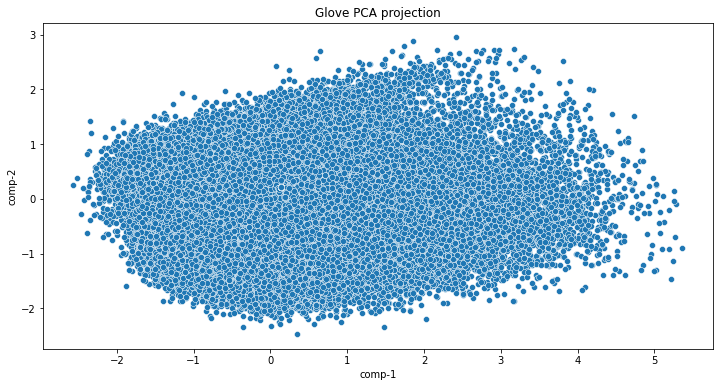

In [ ]:
df3 = pd.DataFrame()
df3["comp-1"] = z[:,0]
df3["comp-2"] = z[:,1]

plt.figure(figsize=(12,6))
sns.scatterplot(x="comp-1", y="comp-2",data=df3).set(title="Glove PCA projection") 

## PCA Projection based on Sentiment

In [ ]:
X = np.sum(X_train,axis=1)
print(X.shape)

(50000, 100)


[Text(0.5, 1.0, 'Glove PCA projection')]

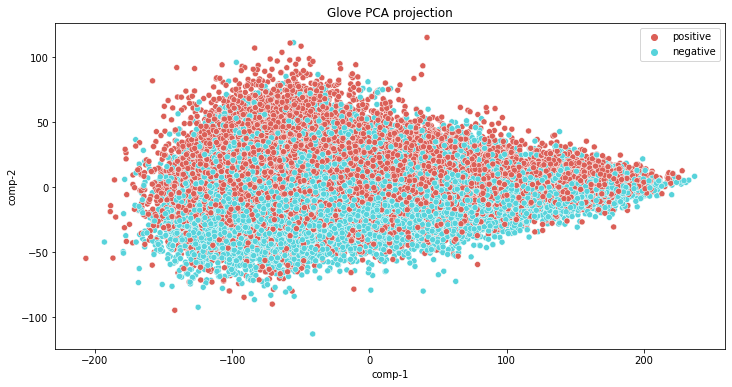

In [ ]:
pca = PCA(n_components=2)

z = pca.fit_transform(X)
df3 = pd.DataFrame()
df3["comp-1"] = z[:,0]
df3["comp-2"] = z[:,1]

plt.figure(figsize=(12,6))
sns.scatterplot(x="comp-1", y="comp-2",hue=df['sentiment'].tolist(),palette=sns.color_palette("hls", 2),data=df3).set(title="Glove PCA projection") 

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

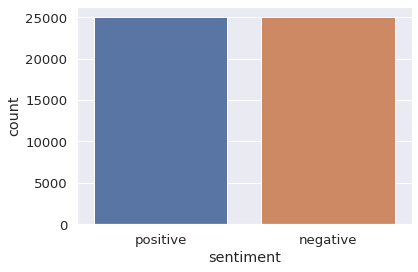

In [ ]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

## Word Cloud

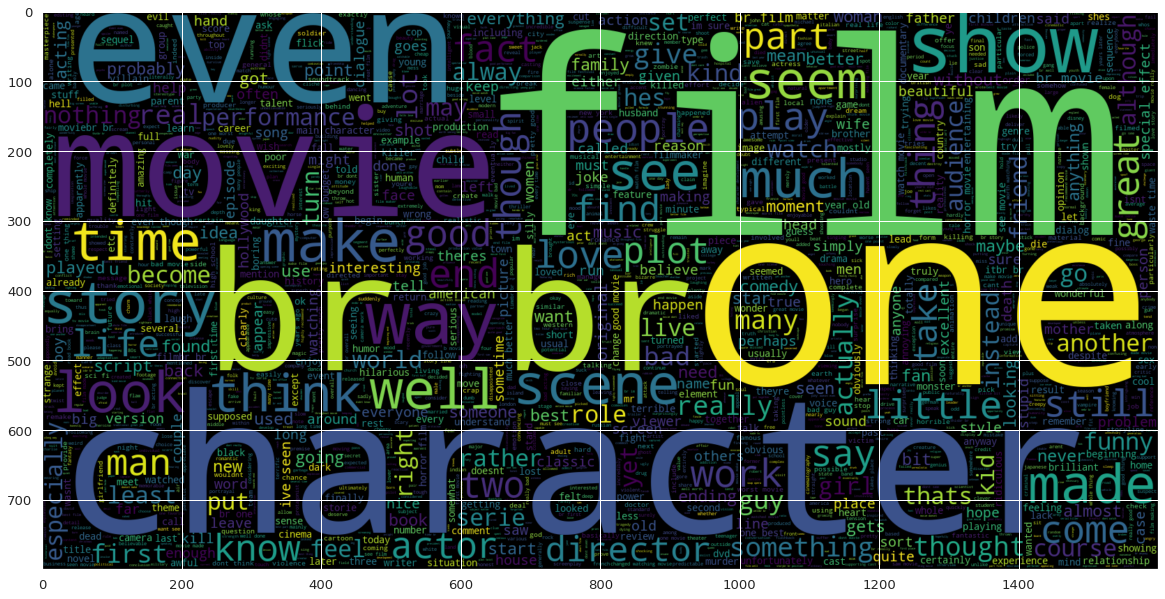

In [ ]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(T))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
Y = df['sentiment'].to_numpy()

In [ ]:
Y

array([1, 1, 1, ..., 0, 0, 0])

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y,test_size=0.2)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(40000, 120, 100)
(10000, 120, 100)


## Torch Tensor and Dataloader

In [ ]:
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(y_train).type(torch.LongTensor)
val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(y_val).type(torch.LongTensor)


trainDataset = TensorDataset(train_features, train_targets)
valDataset = TensorDataset(val_features, val_targets)

In [ ]:
BS = 64

## LSTM Architecture

In [ ]:
class LitLSTM(pl.LightningModule):
    def __init__(self,num_classes,dimension,hidd_dim):
        super(LitLSTM, self).__init__()
        
        self.hidd_dim = hidd_dim
        
        self.LSTM = nn.LSTM(input_size=dimension,
                            hidden_size=self.hidd_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.model = nn.Sequential( nn.Dropout(p=0.5),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(self.hidd_dim, num_classes),
                                    nn.LogSoftmax(dim=1))
        
        # add metrics
        self.train_acc = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1(average="micro")
        self.val_acc = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1(average="micro")
        
    def forward(self, x):
        #h_0 = torch.tensor(torch.rand(2, BS, self.hidd_dim)).to(device)
        #c_0 = torch.tensor(torch.rand(2, BS, self.hidd_dim)).to(device)
        #(h_0,c_0)
        out, (final_hidden_state, final_cell_state) = self.LSTM(x)
        out = self.model(final_hidden_state[-1])
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()
        loss = lossfn(outputs, labels)
        
        y_pred = torch.exp(outputs)
        #y_pred = output.data.max(1, keepdim=True)[1]
        acc = self.train_acc(y_pred, labels)
        f1 = self.train_f1(y_pred, labels)
        # just accumulate

        self.log("train_loss", loss)
        self.log("train_accuracy", acc)
        self.log("train_f1", f1)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=4,batch_size=BS, shuffle=True,drop_last=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=4,batch_size=BS,shuffle=False,drop_last=True)
        
        return valDataLoader
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.NLLLoss()
        loss = lossfn(outputs, labels)
        
        pred = torch.exp(outputs)
        #pred = output.data.max(1, keepdim=True)[1]
        self.val_acc.update(pred, labels)
        self.val_f1.update(pred, labels)

        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def training_epoch_end(self, training_step_outputs):
        # compute metrics
        train_accuracy = self.train_acc.compute()
        train_f1 = self.train_f1.compute()
        # log metrics
        self.log("epoch_train_accuracy", train_accuracy)
        self.log("epoch_train_f1", train_f1)
        # reset all metrics
        self.train_acc.reset()
        self.train_f1.reset()
        print(f"\ntraining accuracy: {train_accuracy:.4}, "\
        f"f1: {train_f1:.4}")
        
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_accuracy = self.val_acc.compute()
        val_f1 = self.val_f1.compute()
        # log metrics
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", avg_loss)
        self.log("val_f1", val_f1)
        # reset all metrics
        self.val_acc.reset()
        self.val_f1.reset()
        print(f"\nvalidation accuracy: {val_accuracy:.4} "\
        f"f1: {val_f1:.4}")
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

## Early Stopping

In [ ]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-5,
    divergence_threshold=9.0,
    check_finite=True)

## Training

In [ ]:
model = LitLSTM(dimension=X_train.shape[2],hidd_dim=128,num_classes=2)
trainer = Trainer(accelerator='gpu',devices=1,max_epochs=100,log_every_n_steps=8,callbacks=[early_stopping])
trainer.fit(model)

Sanity Checking: 0it [00:00, ?it/s]


validation accuracy: 0.5312 f1: 0.5312


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


validation accuracy: 0.6956 f1: 0.6956

training accuracy: 0.6661, f1: 0.6661


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8266 f1: 0.8266

training accuracy: 0.8027, f1: 0.8027


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8393 f1: 0.8393

training accuracy: 0.8321, f1: 0.8321


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8477 f1: 0.8477

training accuracy: 0.8446, f1: 0.8446


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8457 f1: 0.8457

training accuracy: 0.8546, f1: 0.8546


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8541 f1: 0.8541

training accuracy: 0.8619, f1: 0.8619


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8586 f1: 0.8586

training accuracy: 0.8688, f1: 0.8688


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8564 f1: 0.8564

training accuracy: 0.8778, f1: 0.8778


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8611 f1: 0.8611

training accuracy: 0.8846, f1: 0.8846


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8544 f1: 0.8544

training accuracy: 0.8942, f1: 0.8942


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8596 f1: 0.8596

training accuracy: 0.9049, f1: 0.9049


Validation: 0it [00:00, ?it/s]


validation accuracy: 0.8591 f1: 0.8591

training accuracy: 0.9136, f1: 0.9136


## Predict On Review

In [ ]:
def predsentiment(rev):
    print(rev)
    print("==========================================================================================================================================")
    dftest = pd.DataFrame(columns=['review'])
    dftest = dftest.append({'review': rev}, ignore_index=True)
    T = dftest['review'].str.split(' \n\n---\n\n').str[0]
    T = T.str.replace('-',' ').str.replace('[^\w\s]','').str.replace('\n',' ').str.lower()
    stop = stopwords.words('english')
    T = T.apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
    T = T.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
    x,_,_ = Sentence2Vec(T)
    print("==========================================================================================================================================")
    X_test = torch.Tensor(x)
    with torch.no_grad():
        output = model(X_test)
        output = torch.exp(output)
        #print(output)
        index = output.data.cpu().numpy().argmax()
        result = list(np.around(output.data.cpu().numpy()*100,1))
        print("PREDICTION PROBABILITY = ",result)
        strn = "POSITIVE"
        if(index==0): strn = "NEGATIVE"  
        print("PREDICTED CLASS = ",strn)

## Review from Movie RRR

In [ ]:
rev = "Films like this make you feel Proud of Indian Artistry. Rajamouli has created yet another Landmark Cinema in Indian Film History, taking two real life revolutionaries and designing a fictional story with overarching themes of Friendship & Patriotism. Right from the get go, your jaw is left hanging with Unbelievably choreographed Action Scenes and till the end those just keep on coming. SSR knows how to extract genuine emotion from the story and actors, and this time also he excels. The brotherhood between Jr NTR & Ram Charan is something special, with both getting plenty of moments to shine. They have devoted their souls for this film. Incredible Cinematography & Shot selection by Senthil Kumar. MM Keeravani's BGM makes your hairs stand up And surges you with energy. 3 hours fly by as no scene feels redundant. The 3D & VFX is surprisingly good except a few lapses. Do watch this in a 3D theater with great sound, otherwise you will miss an unimaginable experience."
predsentiment(rev)

Films like this make you feel Proud of Indian Artistry. Rajamouli has created yet another Landmark Cinema in Indian Film History, taking two real life revolutionaries and designing a fictional story with overarching themes of Friendship & Patriotism. Right from the get go, your jaw is left hanging with Unbelievably choreographed Action Scenes and till the end those just keep on coming. SSR knows how to extract genuine emotion from the story and actors, and this time also he excels. The brotherhood between Jr NTR & Ram Charan is something special, with both getting plenty of moments to shine. They have devoted their souls for this film. Incredible Cinematography & Shot selection by Senthil Kumar. MM Keeravani's BGM makes your hairs stand up And surges you with energy. 3 hours fly by as no scene feels redundant. The 3D & VFX is surprisingly good except a few lapses. Do watch this in a 3D theater with great sound, otherwise you will miss an unimaginable experience.
number of word in vocab

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


Loaded 400000 word vectors.
(1, 120, 100)
PREDICTION PROBABILITY =  [array([ 0.1, 99.9], dtype=float32)]
PREDICTED CLASS =  POSITIVE


## Review from movie RACE-3

In [ ]:
test_review = "You can compare race 3 to tamil movies. Not a single realistic thing or fight. Everything has been exaggerated.There is all this stupid suspense, but to make the movie look like more suspenseful and complicated they have generated too many relations and all of them are predictable.I would suggest if you are a fan of Salman khan then do not watch the movie coz you will be disappointed. But if you are a fan of race series then do watch it for fun or anything you feel like and digest it someway because race 4 might be on its track. And in other situation if you are none then don't waste your time and money here."

predsentiment(test_review)

You can compare race 3 to tamil movies. Not a single realistic thing or fight. Everything has been exaggerated.There is all this stupid suspense, but to make the movie look like more suspenseful and complicated they have generated too many relations and all of them are predictable.I would suggest if you are a fan of Salman khan then do not watch the movie coz you will be disappointed. But if you are a fan of race series then do watch it for fun or anything you feel like and digest it someway because race 4 might be on its track. And in other situation if you are none then don't waste your time and money here.
number of word in vocabulary 44
word in sentences are replaced with word ID [[ 6  1  7  8  9 10 11 12 13 14 15 16 17  2 18  3 19 20 21 22 23 24 25 26
   4 27 28  5  2 29 30  4  1 31  5 32 33 34  3 35 36  1 37 38 39 40 41 42
  43 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


Loaded 400000 word vectors.
(1, 120, 100)
PREDICTION PROBABILITY =  [array([99.9,  0.1], dtype=float32)]
PREDICTED CLASS =  NEGATIVE
